# システム
- 出発地から目的地までの歩行者移動時間を計算
- 経路・出発時間・歩行速度を指定
- 信号の制御情報はあらかじめ分かっている状態

## 必要なライブラリをインストール・インポート

In [1]:
!pip install pillow

In [2]:
import json
import math
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## 信号クラス

In [3]:
class Signal:
    """ 信号クラス """

    def __init__(self, cycle: int, green_duration: int, offset: int) -> None :
        """
        コンストラクタ

        Parameters
        ----------
        cycle : int
            信号周期
        green_duration : int
            緑信号の点灯継続時間（点滅時間は含まない）
        offset : int
            0時（ある基準の時刻）から初めて緑信号になるまでの時間
        """
        # 信号の状態（True:緑, False:緑以外）
        self.green = False
        self.cycle = cycle
        self.green_duration = green_duration
        self.offset = offset

    def update_status(self, current_time: float) -> None:
        """
        信号の状態を更新

        Parameters
        ----------
        current_time : float
            シミュレーション開始からの経過時間
        """
        # 信号周期内での時間
        c_time = (current_time - self.offset) % self.cycle

        # 緑信号の場合
        if (0 <= c_time < self.green_duration):
            self.green = True
        # 緑信号でない場合
        else:
            self.green = False

    def get_status(self) -> bool:
        """
        現在の信号の状態を取得

        Returns
        -------
        green : bool
            信号の状態（True:緑, False:緑以外）
        """
        return self.green

## JSONファイルの読み込み

In [4]:
with open("network.json", "r") as f:
    network_data = json.load(f)

print(f"Length: {len(network_data)}")
print(network_data[:5])

Length: 112
[{'id': 1, 'type': 'crosswalk', 'distance': 15.0, 'cycle': 70, 'green_duration': 20, 'offset': 25}, {'id': 2, 'type': 'crosswalk', 'distance': 15.0, 'cycle': 70, 'green_duration': 20, 'offset': 25}, {'id': 3, 'type': 'crosswalk', 'distance': 18.0, 'cycle': 70, 'green_duration': 22, 'offset': 55}, {'id': 4, 'type': 'crosswalk', 'distance': 18.0, 'cycle': 70, 'green_duration': 22, 'offset': 55}, {'id': 5, 'type': 'sidewalk', 'distance': 100.0}]


## 読み込んだJSONデータをDataFrameに変換

In [5]:
network_df = pd.DataFrame(network_data)

print(network_df.shape)
network_df.head(10)

(112, 6)


,id,type,distance,cycle,green_duration,offset
0,1,crosswalk,15.0,70.0,20.0,25.0
1,2,crosswalk,15.0,70.0,20.0,25.0
2,3,crosswalk,18.0,70.0,22.0,55.0
3,4,crosswalk,18.0,70.0,22.0,55.0
4,5,sidewalk,100.0,NaN,NaN,NaN
5,6,sidewalk,100.0,NaN,NaN,NaN
6,7,crosswalk,16.0,80.0,20.0,65.0
7,8,crosswalk,16.0,80.0,20.0,65.0
8,9,crosswalk,18.0,80.0,22.0,30.0
9,10,crosswalk,18.0,80.0,22.0,30.0


## 歩道ネットワークの表示

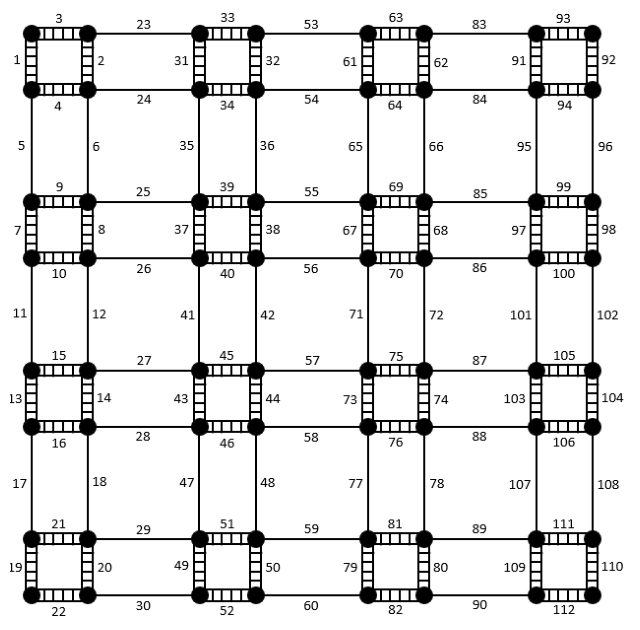

In [6]:
image = Image.open("network.png")
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.show()

## 移動時間を計算

In [7]:
if __name__ == "__main__":
    # 出発地から目的地までの経路
    route = [1, 5, 9, 8, 26, 41, 45, 44, 48, 59, 81, 89, 109, 112]
    # 歩行速度 [m/s]
    walking_speed = 1.2
    # 出発時間
    start_time = 10.0
    # 現在時刻
    current_time = start_time

    # 各経路上の歩行時間を計算
    for path_id in route:
        # 経路情報
        path_df = network_df[network_df["id"] == path_id]
        path_id = int(path_df["id"].values[0])
        path_type = path_df["type"].values[0]
        path_distance = path_df["distance"].values[0]

        # 経路の種類が歩道の場合
        if path_type == "sidewalk":
            print(f"Sidewalk {path_id}")
            print(f"Arrival time: {current_time}")

            # 歩行時間=距離/歩行速度
            walking_time = path_distance / walking_speed
            current_time += walking_time
            print(f"Walking time: {walking_time}\n")

        # 経路の種類が横断歩道の場合
        elif path_type == "crosswalk":
            print(f"Crosswalk {path_id}")
            print(f"Arrival time: {current_time}")
            arrival_time = current_time

            # 信号情報
            cycle = int(path_df["cycle"].values[0])
            green_duration = int(path_df["green_duration"].values[0])
            offset = int(path_df["offset"].values[0])
            signal = Signal(cycle, green_duration, offset)

            # 緑信号になるまで繰り返す
            while True:
                # 信号の状態を更新
                signal.update_status(current_time)

                # 緑信号の場合
                if (signal.get_status() == True):
                    print(f"Waiting time: {current_time - arrival_time}")
                    print(f"Time to start crossing: {current_time}")
                    break

                # 現在時刻を更新
                if (current_time % 1 == 0):
                    current_time += 1
                else:
                    current_time = math.ceil(current_time)

            # 歩行時間=距離/歩行速度
            walking_time = path_distance / walking_speed
            current_time += walking_time
            print(f"Walking time: {walking_time}\n")

    print(f"Start time at starting point (ID {route[0]}): {start_time}")
    print(f"Arrival time at destination (ID {route[-1]}): {current_time}")
    print(f"Travel time: {current_time - start_time}")

Crosswalk 1
Arrival time: 10.0
Waiting time: 15.0
Time to start crossing: 25.0
Walking time: 12.5

Sidewalk 5
Arrival time: 37.5
Walking time: 83.33333333333334

Crosswalk 9
Arrival time: 120.83333333333334
Waiting time: 0.0
Time to start crossing: 120.83333333333334
Walking time: 15.0

Crosswalk 8
Arrival time: 135.83333333333334
Waiting time: 9.166666666666657
Time to start crossing: 145
Walking time: 13.333333333333334

Sidewalk 26
Arrival time: 158.33333333333334
Walking time: 83.33333333333334

Sidewalk 41
Arrival time: 241.66666666666669
Walking time: 250.0

Crosswalk 45
Arrival time: 491.6666666666667
Waiting time: 18.333333333333314
Time to start crossing: 510
Walking time: 18.333333333333336

Crosswalk 44
Arrival time: 528.3333333333334
Waiting time: 41.66666666666663
Time to start crossing: 570
Walking time: 16.666666666666668

Sidewalk 48
Arrival time: 586.6666666666666
Walking time: 166.66666666666669

Sidewalk 59
Arrival time: 753.3333333333333
Walking time: 125.0

Crosswa